In [1]:
%%capture

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Important header information
naluhelperdir = '../utilities'
# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, naluhelperdir)
import plotABLstats
import yaml as yaml
from IPython.display import Image
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
%matplotlib inline
# Define a useful function for pull stuff out of dicts
getparam = lambda keylabel, pdict, default: pdict[keylabel] if keylabel in pdict else default

In [2]:
# DanAero Data
# See /ascldap/users/lcheung/GPFS1/2020/IEATask29/Field measurements Tjaereborg/Calibrated data/InflowLoadsAerodynamicsMeasurements_35Hz/PythonAnalysis/avgcolsWS.dat
# Run 16-07-2009/Tjaereborg_20090716_1250_000035.tim
DanAeroZ  = [17,        28.5,      41,        57,        77,        90]
DanAeroWS = [5.884,     5.973,     5.931,     6.128,     6.028,     6.088]

DanAeroZ2 = [17.574,    29.474,    41.739,    57.3,      77.254,    93.547]
DanAeroTI = [10.1274,   9.2976,    8.1857,    6.6971,    7.3315,    7.4028]

           #   WS,   TI,    alpha
TargetData = [[6.1, 0.068, 0.025]]

In [3]:
# Locations of all of the runs
#baserundir = '/ascldap/users/lcheung/GPFS1/2020/IEATask29/precursor/'
baserundir = './'
NumReqCols = 4   # Number of required columns in the table

# Index of all runs here
runlist=[
    # Name,          Location,                    averaging times,  yaml file, extra dict
    # -- Coarse runs --
    #['Coarse 1',  '/REF1/coarse_iter01',  [10000, 20000], 'abl_DanAeroREF1_iter01_run1.yaml', 
    #   {'ablfile':'abl_statistics.nc', 'color':'g', 'lstyle':'-', 'lw':2.5}],    
    #['Coarse 2.1',  '/REF1/coarse_iter02',  [2000, 20000], 'abl_DanAeroREF1_iter02_run1.yaml', 
    #   {'ablfile':'abl_statistics.nc.run1', 'color':'g', 'lstyle':'--', 'lw':2.5}],    
    #['Coarse 2.2',  '/REF1/coarse_iter02',  [1000, 20000], 'abl_DanAeroREF1_iter02_run2.yaml', 
    #   {'ablfile':'abl_statistics.nc.run2', 'color':'g', 'lstyle':'-.', 'lw':2.5}],    
    #['Coarse 2.3',  '/REF1/coarse_iter02',  [2500, 20000], 'abl_DanAeroREF1_iter02_run3.yaml', 
    #   {'ablfile':'abl_statistics.nc.run3', 'color':'g', 'lstyle':'-', 'lw':1}],    
    #['Coarse 2',  '/REF1/coarse_iter02',  [2500, 20000], 'abl_DanAeroREF1_iter02_run4.yaml', 
    #   {'ablfile':'abl_statistics.nc', 'color':'g', 'lstyle':'-', 'lw':2.5}],    
    #['Coarse 4',  '/REF1/coarse_iter04',  [10000, 20000], 'abl_DanAeroREF1_iter02_run4.yaml', 
    #   {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'-', 'lw':2.5}],    
    #['Coarse 5',  '/REF1/coarse_iter05',  [10000, 20000], 'abl_DanAeroREF1_iter02_run4.yaml', 
    #   {'ablfile':'abl_statistics.nc', 'color':'b', 'lstyle':'-', 'lw':2.5}],    
    #['Coarse 6',  '/REF1/coarse_iter06',  [15000, 20000], 'abl_DanAeroREF1_iter02_run4.yaml', 
    #   {'ablfile':'abl_statistics.nc', 'color':'g', 'lstyle':'-', 'lw':1}],    
    #['Nalu-Wind [old BC]',  '/REF1/coarse_iter07',  [15000, 20000], 'abl_DanAeroREF1_iter02_run4.yaml', 
    #    {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'-', 'lw':1}],    
    #['Big 7',     '/REF1/big_iter07',  [4000, 20000], 'abl_DanAeroREF1_iter07_run1.yaml', 
    #    {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'-', 'lw':2.5}],    
    #['Nalu-Wind [new BC]',     '/REF1/newBC_iter07',  [15000, 20000], 'abl_DanAeroREF1_iter07_run1.yaml', 
    #    {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'--', 'lw':2.5}],    

    ['Nalu-Wind [old BC]',  'NaluWind_oldBC/',  [15000, 20000], 'abl_DanAeroREF1_iter02_run4.yaml', 
        {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'-', 'lw':1}],    
    ['Nalu-Wind [new BC]',  'NaluWind_newBC.refT/',  [15000, 20000], 'abl_DanAeroREF1_iter07_run1.yaml', 
        {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'--', 'lw':2.5}],    
    #['Nalu-Wind [new BC]',  'NaluWind_newBC/',  [15000, 20000], 'abl_DanAeroREF1_iter07_run1.yaml', 
    #    {'ablfile':'abl_statistics.nc', 'color':'r', 'lstyle':'--', 'lw':2.5}],    

]

# Hub-height locations
plotheights=[57.19]

In [4]:
#%%capture
# Pull the data from disk
alldata=[]
allVdata=[]
allTIdata=[]
allTdata=[]
allVeerdata=[]
allutau=[]
allREstresses=[]
for run in runlist:
    print(run[0])
    rundict       = run[NumReqCols] if (len(run)>NumReqCols) else {}
    statsfile     = rundict['ablfile'] if 'ablfile' in rundict else 'abl_statistics.nc'
    rundir        = baserundir+'/'+run[1]
    avgtimes      = run[2]
    data          = plotABLstats.ABLStatsFileClass(stats_file=rundir+'/'+statsfile);
    runresults    = plotABLstats.reportABLstats(data, heights=plotheights, tlims=avgtimes);
    alldata.append(runresults[0])
    utau          = plotABLstats.avgutau(data, heights=plotheights, tlims=avgtimes);
    allutau.append(utau)
    
    # Profile information
    Vprof,    Vheader    = plotABLstats.plotvelocityprofile(data, None, tlims=avgtimes, exportdata=True)
    TIprof,   TIheader   = plotABLstats.plotTIstreamwiseprofile(data, None, tlims=avgtimes, exportdata=True)
    Tprof,    Theader    = plotABLstats.plottemperatureprofile(data, None, tlims=avgtimes, exportdata=True)
    Veerprof, Veerheader =plotABLstats.plotveerprofile(data, None, tlims=avgtimes, exportdata=True)
    # Extract TKE and Reynolds stresses
    REstresses, REheader = plotABLstats.plottkeprofile(data, None, tlims=avgtimes, exportdata=True)
    
    allVdata.append(Vprof)
    allTIdata.append(TIprof)
    allTdata.append(Tprof)
    allVeerdata.append(Veerprof)
    allREstresses.append(REstresses)
allrundata=np.array(alldata)

Nalu-Wind [old BC]
The netcdf file contains the variables:
(u'time', (12001,))
(u'heights', (267,))
(u'density', (12001, 267))
(u'velocity', (12001, 267, 3))
(u'velocity_tavg', (12001, 267, 3))
(u'sfs_stress', (12001, 267, 6))
(u'resolved_stress', (12001, 267, 6))
(u'sfs_stress_tavg', (12001, 267, 6))
(u'resolved_stress_tavg', (12001, 267, 6))
(u'temperature', (12001, 267))
(u'temperature_tavg', (12001, 267))
(u'temperature_sfs_flux_tavg', (12001, 267, 3))
(u'temperature_resolved_flux', (12001, 267, 3))
(u'temperature_variance', (12001, 267))
(u'temperature_resolved_flux_tavg', (12001, 267, 3))
(u'temperature_variance_tavg', (12001, 267))
(u'utau', (12001,))

        z        u_mag           TI        alpha         Wdir         Ob.L
      ===          ===          ===          ===          ===          ===
    57.19 6.129975e+00 6.732005e-02 2.093954e-02 2.300725e+02 -5.160691e+01

AVG Utau = 1.991429e-01
Nalu-Wind [new BC]
The netcdf file contains the variables:
(u'time', (40001,))
(u

In [5]:
# Save the data to text files
for irun, row in enumerate(runlist):
    rundir        = baserundir+'/'+row[1]
    # Save velocity
    np.savetxt(rundir+'/NaluWind_velocity.dat',         allVdata[irun], header=Vheader)
    np.savetxt(rundir+'/NaluWind_temperature.dat',      allTdata[irun], header=Theader)
    np.savetxt(rundir+'/NaluWind_reynoldsstresses.dat', allREstresses[irun], header=REheader)

In [6]:
# Print a pretty table of the hub-height results
print("%-22s %8s %8s %10s %12s %15s %12s"%("Name", "WS [m/s]","TI [-]","Alpha [-]","WDir [deg]","Obukhov L[m]","Utau [m/s]"))
print("%-22s %8s %8s %10s %12s %15s %12s"%("====", "========","======","=========","==========","============","=========="))
for ir, row in enumerate(runlist):
    name = row[0]
    data = alldata[ir]
    print("%-22s %8.2f %8.4f %10.4f %12.2f %15.3e %12.4f"%(name, data[0], data[1], data[2], data[3],data[4],allutau[ir]))

Name                   WS [m/s]   TI [-]  Alpha [-]   WDir [deg]    Obukhov L[m]   Utau [m/s]
====                   ========   ======  =========   ==========    ============   ==========
Nalu-Wind [old BC]         6.13   0.0673     0.0209       230.07      -5.161e+01       0.1991
Nalu-Wind [new BC]         6.13   0.0690     0.0190       230.07      -5.848e+01       0.2071


In [7]:
# Print a pretty table of the hub-height results
print("%-22s %8s %8s %10s "%("Name", "WS [m/s]","TI [-]","Alpha [-]"))
print("%-22s %8s %8s %10s "%("====", "========","======","========="))
for ir, row in enumerate(runlist):
    name = row[0]
    data = alldata[ir]
    print("%-22s %8.1f %8.4f %10.4f"%(name, data[0], data[1], data[2]))
print("%-22s %8.1f %8.4f %10.4f"%("EMPT-REF-1", TargetData[0][0], TargetData[0][1], TargetData[0][2]))

Name                   WS [m/s]   TI [-]  Alpha [-] 
====                   ========   ======  ========= 
Nalu-Wind [old BC]          6.1   0.0673     0.0209
Nalu-Wind [new BC]          6.1   0.0690     0.0190
EMPT-REF-1                  6.1   0.0680     0.0250


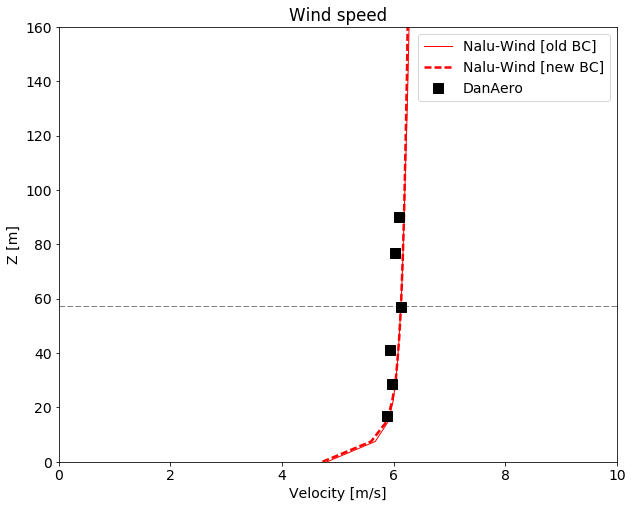

In [8]:
# Plot the velocity profile comparisons
plt.figure(figsize=(10,8));
plt.rc('font', size=14)
for irun, run in enumerate(runlist):
    rundict  = runlist[irun][NumReqCols] if len(runlist[irun])>NumReqCols else {}
    pltcolor = getparam('color', rundict, 'b')
    lstyle   = getparam('lstyle', rundict, '-') 
    lw       = getparam('lw', rundict, 1) 
    label    = run[0]
    Vprof    = allVdata[irun]
    plt.plot(Vprof[:,4], Vprof[:,0], linestyle=lstyle, color=pltcolor, linewidth=lw, label=label)
for hh in plotheights: plt.hlines(hh, 0, 30, linestyles='dashed', linewidth=0.5)

plt.plot(DanAeroWS, DanAeroZ, 's', color='k',markersize=10, label='DanAero')
    
# Construct a legend
plt.legend()
plt.ylim([0,160]);
plt.xlim([0, 10])
plt.xlabel('Velocity [m/s]')
plt.ylabel('Z [m]')
#plt.grid()
plt.title('Wind speed')

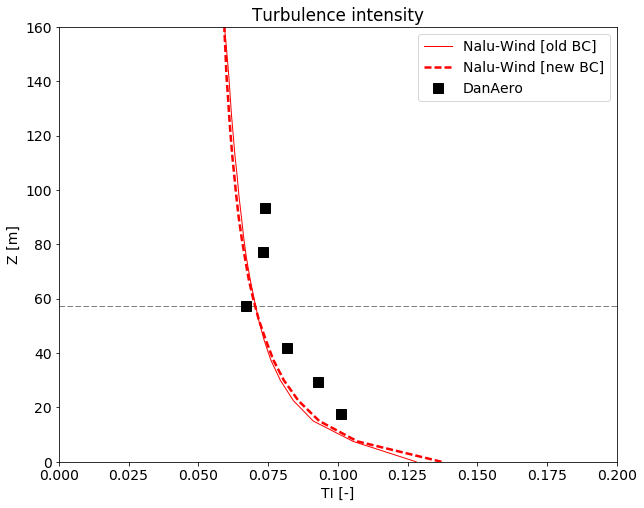

In [9]:
# Plot the TI profile comparisons
plt.figure(figsize=(10,8));
plt.rc('font', size=14)
maxTI=0
for irun, run in enumerate(runlist):
    rundict  = runlist[irun][NumReqCols] if len(runlist[irun])>NumReqCols else {}
    pltcolor = getparam('color', rundict, 'b')
    lstyle   = getparam('lstyle', rundict, '-') 
    lw       = getparam('lw', rundict, 1) 
    label    = run[0]
    TIprof   = allTIdata[irun]
    maxTI=max(maxTI, max(TIprof[:,1]))
    plt.plot(TIprof[:,1], TIprof[:,0], linestyle=lstyle, color=pltcolor, linewidth=lw, label=label)
    
plt.plot(np.array(DanAeroTI)/100, DanAeroZ2, 's', color='k',markersize=10, label='DanAero')

for hh in plotheights: plt.hlines(hh, 0, 0.3, linestyles='dashed', linewidth=0.5)
plt.legend()
plt.ylim([0,160]);
plt.xlim([0, 0.2])
plt.xlabel('TI [-]')
plt.ylabel('Z [m]')
plt.title('Turbulence intensity')

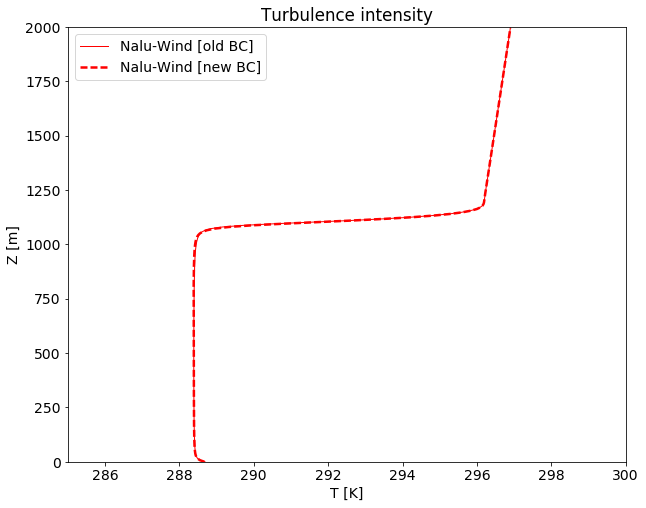

In [10]:
# Plot the Temperature profile comparisons
plt.figure(figsize=(10,8));
plt.rc('font', size=14)
maxT=0
for irun, run in enumerate(runlist):
    rundict  = runlist[irun][NumReqCols] if len(runlist[irun])>NumReqCols else {}
    pltcolor = getparam('color', rundict, 'b')
    lstyle   = getparam('lstyle', rundict, '-') 
    lw       = getparam('lw', rundict, 1) 
    label    = run[0]
    Tprof    = allTdata[irun]
    maxT     = max(maxT, max(Tprof[:,1]))
    plt.plot(Tprof[:,1], Tprof[:,0], linestyle=lstyle, color=pltcolor, linewidth=lw, label=label)
    
#plt.plot(np.array(DanAeroTI)/100, DanAeroZ2, 's', color='k',markersize=10, label='DanAero')

for hh in plotheights: plt.hlines(hh, 0, maxTI, linestyles='dashed', linewidth=0.5)
plt.legend()
plt.ylim([0,2000]);
plt.xlim([285, 300])
plt.xlabel('T [K]')
plt.ylabel('Z [m]')
plt.title('Turbulence intensity')